In [18]:
import math
beta1 = lambda p,a,b: math.gamma(a+b)/(math.gamma(a)*math.gamma(b)) * p**(a-1) * (1-p)**(b-1)

In [19]:
beta1(0.3, 2,4)

2.0579999999999994

In [26]:
from scipy.stats import binom, beta

In [27]:
beta.pdf(0.3,2,4) # p,k,n

2.0580000000000003

In [28]:
binom1 = lambda p,k,n: math.comb(n,k) * p**k * (1-p)**(n-k)

In [29]:
binom1(0.3,3,6)

0.18521999999999994

In [32]:
binom.pmf(3,6,0.3) # k,n,p

0.1852199999999999

In [7]:
import numpy as np
ks = np.array([1,2,3,4])
ns = np.array([5,6,7,8])
binom.pmf(ks,ns,0.3)

NameError: name 'binom' is not defined

ModuleNotFoundError: No module named 'circuit_tools'

In [2]:
import pecos as pc
ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

In [5]:
ct.partition_circuit(ghz, ['p1','p2'])

[[(0, 0)], [(1, (0, 1)), (2, (1, 2)), (3, (2, 3)), (4, (3, 4)), (5, (0, 4))]]

In [20]:
p1 = np.logspace(-3,0,10)
p2 = p1 * 0.5

# print(p1.T,p2.T)
# np.vstack((p1,p2)).T # always need to specify ranges for p1,p2,..

a = {'p1':p1, 'p2':p2}
np.vstack(list(a.values())).T

array([[1.00000000e-03, 5.00000000e-04],
       [2.15443469e-03, 1.07721735e-03],
       [4.64158883e-03, 2.32079442e-03],
       [1.00000000e-02, 5.00000000e-03],
       [2.15443469e-02, 1.07721735e-02],
       [4.64158883e-02, 2.32079442e-02],
       [1.00000000e-01, 5.00000000e-02],
       [2.15443469e-01, 1.07721735e-01],
       [4.64158883e-01, 2.32079442e-01],
       [1.00000000e+00, 5.00000000e-01]])

In [1]:
import sampler
import numpy as np
import pecos as pc
import matplotlib.pyplot as plt

In [2]:
ghz = []
ghz.append(('h', 0))
ghz.append(('cnot', (0,1)))
ghz.append(('cnot', (1,2)))
ghz.append(('cnot', (2,3)))
ghz.append(('cnot', (3,4)))
ghz.append(('cnot', (0,4)))
ghz.append(('measure', 4))

In [3]:
ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

In [3]:
p1 = np.logspace(-3,0,10)
p2 = p1 * 0.5
err_params = {'p1':p1, 'p2':p2}
ds = sampler.DirectSampler(ghz, err_params)

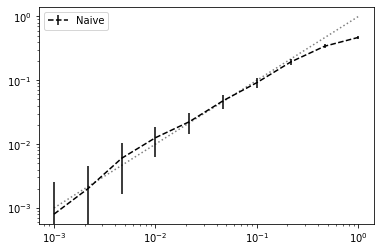

CPU times: user 6.4 s, sys: 133 ms, total: 6.54 s
Wall time: 6.26 s


In [6]:
%%time

p_L, ds_std = ds.run(n_samples=5000)
plt.errorbar(p1, p_L, fmt='--', c="black", yerr=ds_std, label="Naive")
plt.plot(p1,p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

/home/dw/Desktop/HiWi/DSS/sampler.py:83: RuntimeWarning: invalid value encountered in true_divide
  pws = (fail_cnts / cnts)[:,None]
/home/dw/Desktop/HiWi/Circuit Sampling/env/lib/python3.10/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


[2 3 4 2 0 1 3 5] [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]


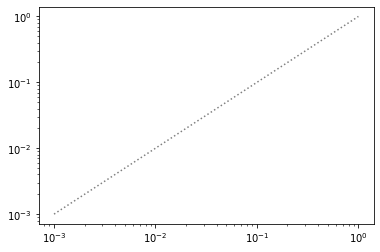

In [9]:
ss = sampler.SubsetSampler(ghz,err_params)
p_L_low, p_L_up, ss_std = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=20)
plt.errorbar(p1, p_L_low, fmt='--', c="black", yerr=ss_std)
plt.errorbar(p1, p_L_up, fmt='--', c="red", yerr=ss_std)

plt.plot(p1,p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.show()

In [5]:
def a(x, b=3, *args, **kwargs):
    print(b)
    return x

a(4,k=2,i=2,j=45)

type([('Y', 1), ('Z', 2)])

3


list

In [71]:
from calc import Metropolis_SS_selector as ms

counts = np.array([1,1,1,1])
fail_counts = np.array([1,0,1,1])
curr_idx = 0

for _ in range(10):
    curr_idx = ms(counts, fail_counts, curr_idx)
    print(curr_idx)

0
0
0
0
0
0
0
0
0
0


In [7]:
import circuit_utils as cu

cu.n_qubits(ghz)

4